In [1]:
!pip install mlxtend==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
df = pd.read_csv("water_potability.csv")

In [4]:
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [5]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
for feature in df.columns:
    if df[feature].isnull().sum()>0:
        print(f"{feature} : {round(df[feature].isnull().mean(),4)*100}%")

ph : 14.99%
Sulfate : 23.84%
Trihalomethanes : 4.95%


In [7]:
## Fill missing values with median
for feature in df.columns:
    df[feature].fillna(df[feature].median() , inplace = True)

In [8]:
## find dublicate rows in dataset
duplicate = df[df.duplicated()]
duplicate

Empty DataFrame
Columns: [ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []

In [9]:
for i in df.columns:
    print(f" {i}  :  {len(df[i].unique())}")

 ph  :  2785
 Hardness  :  3276
 Solids  :  3276
 Chloramines  :  3276
 Sulfate  :  2495
 Conductivity  :  3276
 Organic_carbon  :  3276
 Trihalomethanes  :  3115
 Turbidity  :  3276
 Potability  :  2


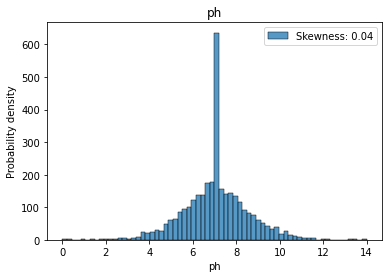

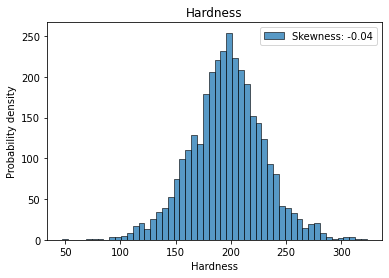

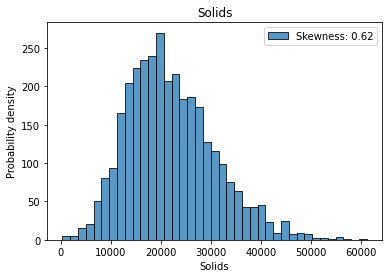

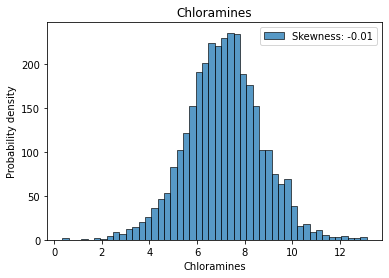

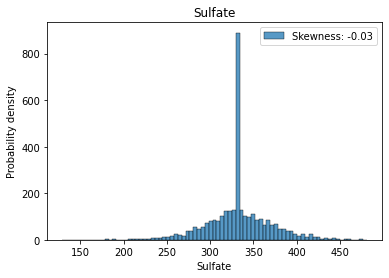

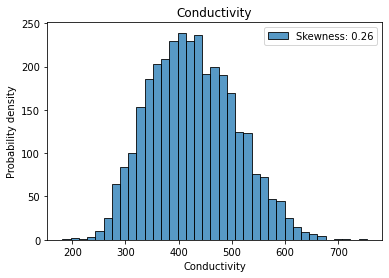

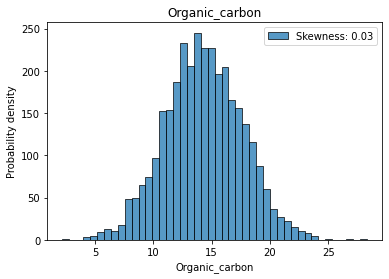

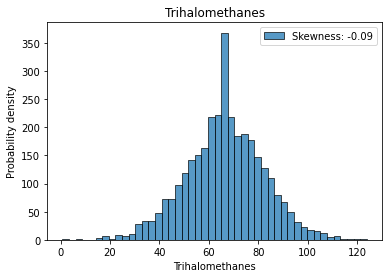

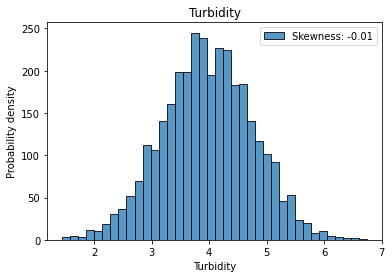

In [10]:
for feature in df.columns:
    if feature == "Potability":
        pass
    else: 
        bar = sns.histplot(df[feature] , kde_kws = {'bw' : 1} , )
        bar.legend(["Skewness: {:0.2f}".format(df[feature].skew())])
        plt.xlabel(feature)
        plt.ylabel("Probability density")
        plt.title(feature)
        plt.show()

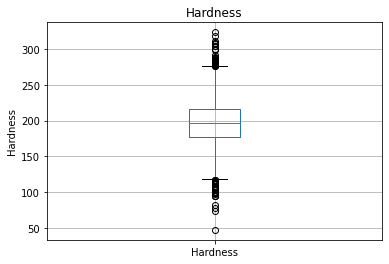

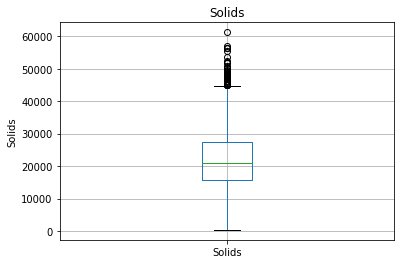

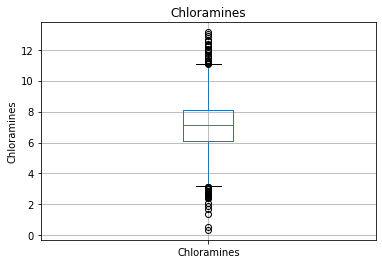

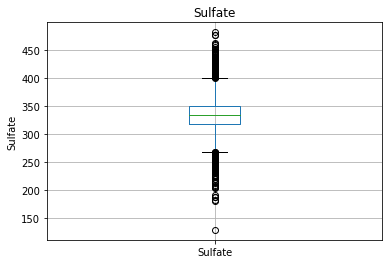

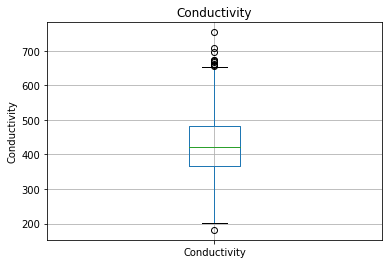

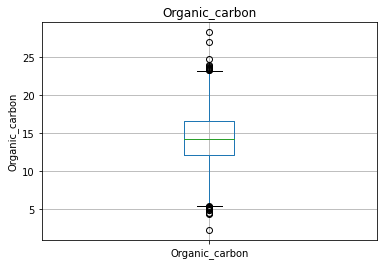

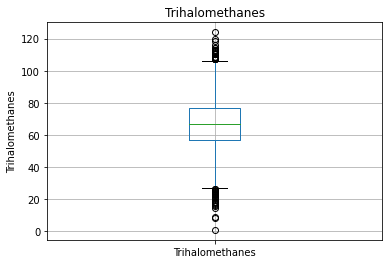

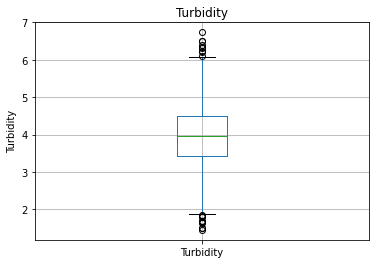

In [11]:
# we don't have missing values in our dataset so we can skip if condition 
for feature in df.columns:
    if 0 in df[feature].unique():# because log 0 is not defined thats why we are using this condition or we can also use log1p
        pass
    else:
        df.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()       

In [12]:
# removing outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ph                     1.592377
Hardness              39.816918
Solids             11666.071830
Chloramines            1.987466
Sulfate               33.291119
Conductivity         116.057890
Organic_carbon         4.491850
Trihalomethanes       20.018954
Turbidity              1.060609
Potability             1.000000
dtype: float64


In [13]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(2666, 10)

In [14]:
df["Potability"].value_counts()

0    1671
1     995
Name: Potability, dtype: int64

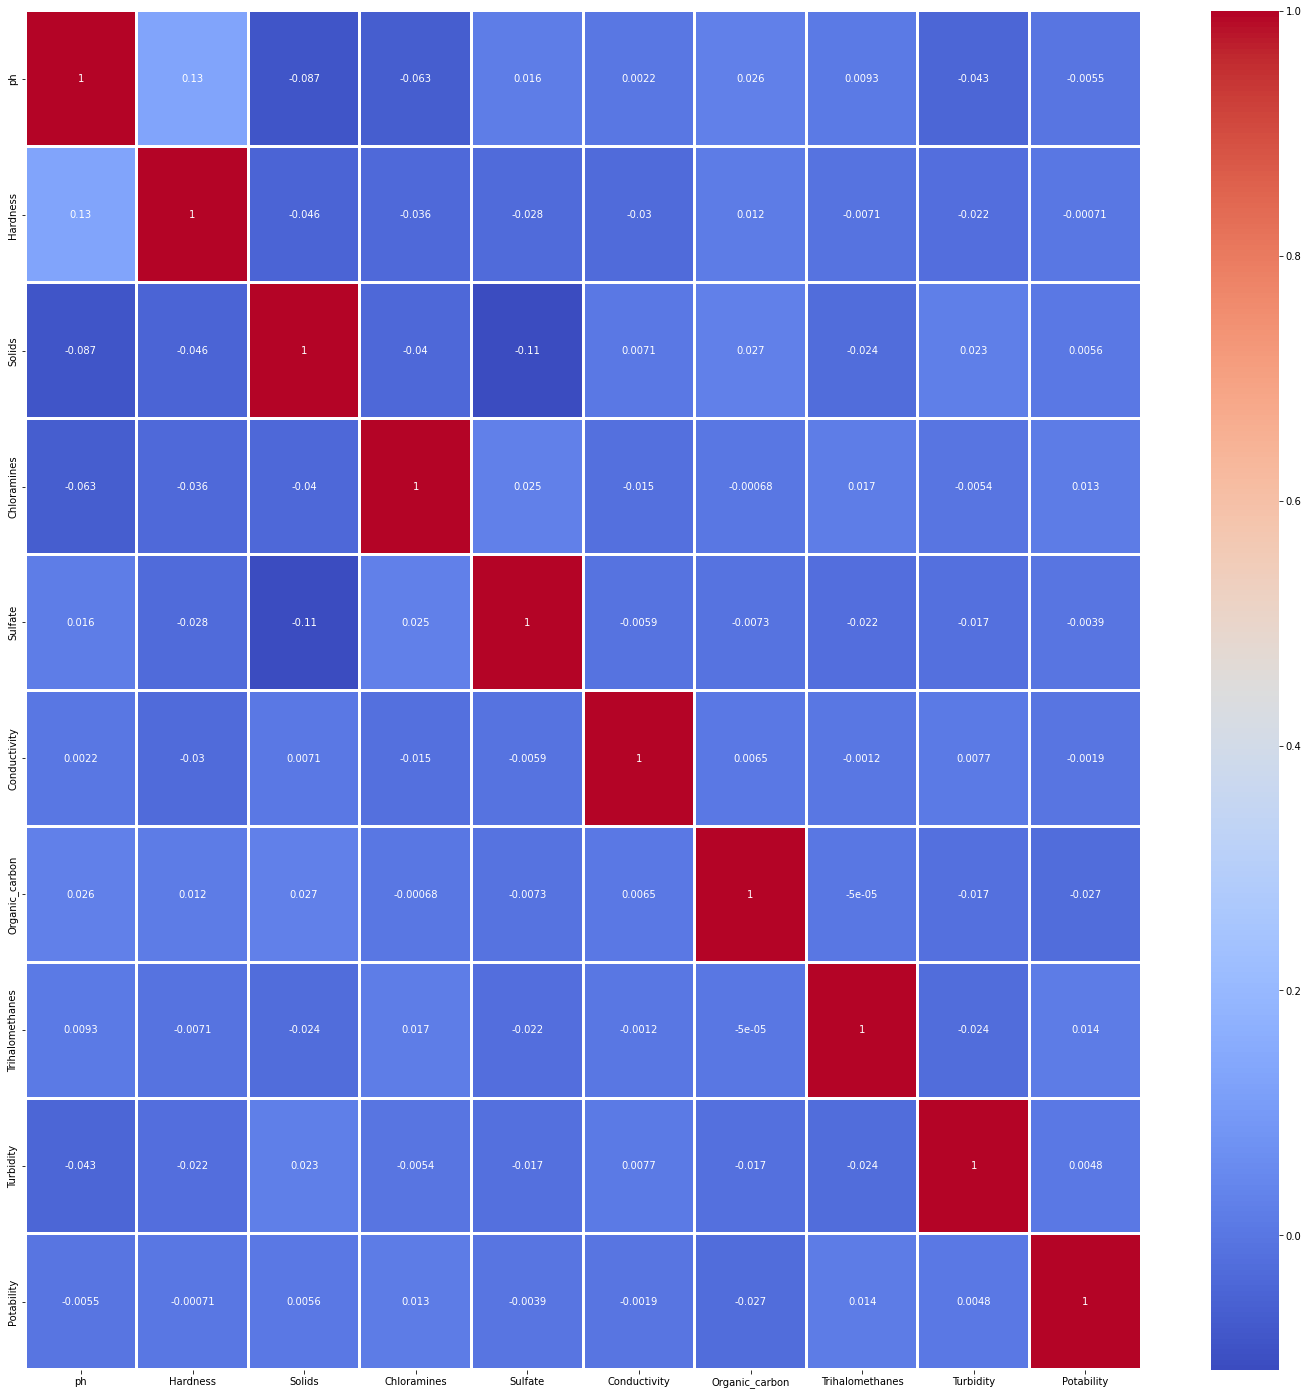

In [15]:
## Correlation
plt.figure(figsize=(25,25))
ax = sns.heatmap(df.corr(), cmap = "coolwarm", annot=True, linewidth=2)

In [16]:
### splitting data into x and y
#y: potability
X = df.iloc[: , : -1]
y = df.iloc[ : , -1]

In [17]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 5)

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_final = sc.fit_transform(X_train)
X_test_final = sc.transform(X_test)

In [19]:
from joblib import dump, load
dump(sc, 'scaler.save', compress=True)

['scaler.save']

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [21]:
# XGBoost Classifier
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(random_state=0)
xgb_classifier.fit(X_train_final, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred_xgb)

0.6104868913857678

In [22]:
# Support vector classifier
from sklearn.svm import SVC
svc_classifier = SVC(class_weight = "balanced" )
svc_classifier.fit(X_train_final, y_train)
y_pred_scv = svc_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred_scv)

0.6310861423220974

In [23]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74       331
           1       0.46      0.15      0.23       203

    accuracy                           0.61       534
   macro avg       0.55      0.52      0.48       534
weighted avg       0.57      0.61      0.55       534



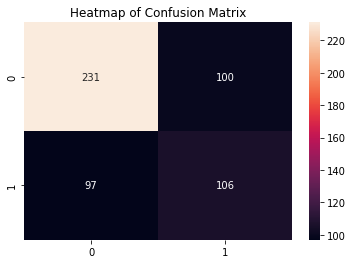

In [24]:
cm = confusion_matrix(y_test, y_pred_scv)
plt.title('Heatmap of Confusion Matrix', fontsize = 12)
sns.heatmap(cm, annot = True , fmt = "d")
plt.show()

In [25]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 200 , 400 , 600 , 800], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [26]:
from sklearn.model_selection import GridSearchCV


In [27]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train_final, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.628 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.628 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.629 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.629 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.629 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.629 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.629 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.629 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.628 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 200, 400, 600, 800],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [28]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


In [29]:
# Support vector classifier
from sklearn.svm import SVC
svc_classifier = SVC(class_weight = "balanced"  , C=100, gamma=0.01)
svc_classifier.fit(X_train_final, y_train)
y_pred_scv = svc_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred_scv)

0.6423220973782772

In [30]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74       331
           1       0.46      0.15      0.23       203

    accuracy                           0.61       534
   macro avg       0.55      0.52      0.48       534
weighted avg       0.57      0.61      0.55       534



In [31]:
## Pickle
from sklearn.svm import SVC
import pickle

# save model
pickle.dump(svc_classifier, open('model.pkl', 'wb'))

# load model
water_quality_model = pickle.load(open('model.pkl', 'rb'))

# predict the output
y_pred =water_quality_model.predict(X_test_final)

# confusion matrix
print('Confusion matrix of Support vector Machine : \n',confusion_matrix(y_test, y_pred),'\n')

Confusion matrix of Support vector Machine : 
 [[243  88]
 [103 100]] 

